# Introduction
Ford GoBike is a regional public bicycle sharing system in the San Francisco Bay Area, California earliar know as Bay Wheels. After Motivate's acquisition by Lyft, the system was subsequently renamed to Bay Wheels in June 2019. The system is expected to expand to 7,000 bicycles around 540 stations in San Francisco, Oakland, Berkeley, Emeryville, and San Jose.
The Ford GoBike fleet consists of three kinds of bicycles: standard docked bicycles with a step-through frame, a docked electric-assist bicycle, and a dockless variant of the standard bicycle equipped with a rear-wheel lock. The stations and standard bikes are provided by 8D Technologies and Motivate. The standard bicycles, dubbed Ford GoBike Classic, are aluminum frame utility bicycles equipped with integrated lighting, front luggage rack, and continuously-variable gear shifting.

The electric bicycles are provided by GenZe and are equipped with a lithium-ion battery and an LCD display with a speedometer. The bikes have a top speed of 18 mph under electric assist. The batteries are currently not automatically charged by the docking stations, which are powered by solar panels, but are instead serviced manually by staff members.

All bicycle docks in the system are equipped with a contactless smart card reader that works with the Clipper card used by the Bay Area's transit agencies. This allows members to tap their Clipper card in order to rent a bicycle without using the dock's electronic kiosk. The Clipper card is only used for identification and cannot be used to pay for bicycle rental from its stored cash. 

The bicycles are available 24 hours a day, seven days a week for periods ranging from a single ride (up to 30 minutes) to a day pass, in 30-minute increments, or customers can purchase an annual subscription which gives them unlimited rides up to 45-minutes in duration.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from geopy.distance import vincenty
from geopy.distance import geodesic
import glob
import os

%matplotlib inline



## combine all 2019 csv files into one single csv

Downloaded all the csv files related to fordGoBike for the year 2019 and merged using below code to
a master csv file

    import csv
    inputs = ["201901.csv", "201902.csv", "201903.csv", "201904.csv", "201905.csv","201906.csv","201907.csv","201908.csv","201909.csv","201910.csv","201911.csv","201912.csv"]  # etc

    #### First determine the field names from the top line of each input file
    #### Comment 1 below
    fieldnames = []
    for filename in inputs:
      with open(filename, "r", newline="") as f_in:
        reader = csv.reader(f_in)
        headers = next(reader)
        for h in headers:
          if h not in fieldnames:
            fieldnames.append(h)

    #### Then copy the data
    with open("master.csv", "w", newline="") as f_out:   # Comment 2 below
      writer = csv.DictWriter(f_out, fieldnames=fieldnames, extrasaction='ignore')
      writer.writeheader()
      for filename in inputs:
        with open(filename, "r", newline="") as f_in:
          reader = csv.DictReader(f_in)  # Uses the field names in this file
          for line in reader:
            # Comment 3 below
            writer.writerow(line)


In [2]:
df = pd.read_csv('master.csv')
df.head()

C:\Users\ma501v\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
0,80825,2019-01-31 17:57:44.6130,2019-02-01 16:24:49.8640,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,No,NaN
1,65900,2019-01-31 20:58:33.8860,2019-02-01 15:16:54.1730,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,No,NaN
2,62633,2019-01-31 18:06:52.9240,2019-02-01 11:30:46.5300,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,No,NaN
3,44680,2019-01-31 19:46:09.7190,2019-02-01 08:10:50.3180,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,No,NaN
4,60709,2019-01-31 14:19:01.5410,2019-02-01 07:10:51.0650,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,-122.388098,2100,Customer,No,NaN


In [3]:
# Get info on the data stored in our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 15 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
bike_share_for_all_trip    object
rental_access_method       object
dtypes: float64(6), int64(2), object(7)
memory usage: 286.9+ MB


In [4]:
# Getting into more details using describe function
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id
count,2.506983e+06,2.426249e+06,2.506983e+06,2.506983e+06,2.424081e+06,2.506983e+06,2.506983e+06,2.506983e+06
mean,8.076483e+02,1.465047e+02,3.776506e+01,-1.223499e+02,1.427044e+02,3.776422e+01,-1.223459e+02,2.789833e+04
std,1.974714e+03,1.223171e+02,1.363698e-01,3.089648e-01,1.214296e+02,2.392885e-01,7.080417e-01,1.146067e+05
min,6.000000e+01,3.000000e+00,0.000000e+00,-1.225143e+02,3.000000e+00,0.000000e+00,-1.225143e+02,4.000000e+00
25%,3.590000e+02,4.700000e+01,3.776931e+01,-1.224130e+02,4.300000e+01,3.777003e+01,-1.224117e+02,1.952000e+03
50%,5.710000e+02,1.050000e+02,3.778053e+01,-1.223983e+02,1.010000e+02,3.778076e+01,-1.223981e+02,4.420000e+03
75%,8.870000e+02,2.430000e+02,3.779539e+01,-1.222914e+02,2.390000e+02,3.779587e+01,-1.222934e+02,9.682000e+03
max,9.121100e+05,4.980000e+02,4.551000e+01,0.000000e+00,4.980000e+02,4.551000e+01,0.000000e+00,9.999410e+05


In [5]:
# identify null values in dataset
df.isnull().sum()

duration_sec                     0
start_time                       0
end_time                         0
start_station_id             80734
start_station_name           80133
start_station_latitude           0
start_station_longitude          0
end_station_id               82902
end_station_name             82350
end_station_latitude             0
end_station_longitude            0
bike_id                          0
user_type                        0
bike_share_for_all_trip     101066
rental_access_method       2389169
dtype: int64

In [6]:
# check if we have any duplicates
df.duplicated().sum()

0

In [7]:
# check if dataset has any NaN values
df.isna().sum()

duration_sec                     0
start_time                       0
end_time                         0
start_station_id             80734
start_station_name           80133
start_station_latitude           0
start_station_longitude          0
end_station_id               82902
end_station_name             82350
end_station_latitude             0
end_station_longitude            0
bike_id                          0
user_type                        0
bike_share_for_all_trip     101066
rental_access_method       2389169
dtype: int64

In [8]:
# identify null values in dataset
df.isnull().sum()

duration_sec                     0
start_time                       0
end_time                         0
start_station_id             80734
start_station_name           80133
start_station_latitude           0
start_station_longitude          0
end_station_id               82902
end_station_name             82350
end_station_latitude             0
end_station_longitude            0
bike_id                          0
user_type                        0
bike_share_for_all_trip     101066
rental_access_method       2389169
dtype: int64

In [9]:
# check if dataset has any NaN values
df.isna().sum()

duration_sec                     0
start_time                       0
end_time                         0
start_station_id             80734
start_station_name           80133
start_station_latitude           0
start_station_longitude          0
end_station_id               82902
end_station_name             82350
end_station_latitude             0
end_station_longitude            0
bike_id                          0
user_type                        0
bike_share_for_all_trip     101066
rental_access_method       2389169
dtype: int64

#### We have certain rows which have null or nan values for now but our observations are not based on those feilds so will try to keep them as they are

In [10]:
# Change start_time and end_time to datetime format
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 15 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
bike_share_for_all_trip    object
rental_access_method       object
dtypes: datetime64[ns](2), float64(6), int64(2), object(5)
memory usage: 286.9+ MB


In [11]:
# changing user_type to catagory type
df.user_type = df.user_type.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 15 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  category
bike_share_for_all_trip    object
rental_access_method       object
dtypes: category(1), datetime64[ns](2), float64(6), int64(2), object(4)
memory usage: 270.2+ MB


In [12]:
# Creating two new columns for day of week and start time 
df["start_day_of_week"] = df["start_time"].dt.strftime('%a')
df["starting_hour"] = df["start_time"].dt.hour
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 17 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  category
bike_share_for_all_trip    object
rental_access_method       object
start_day_of_week          object
starting_hour              int64
dtypes: category(1), datetime64[ns](2), float64(6), int64(3), object(5)
memory usage: 308.4+ MB


In [13]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method,start_day_of_week,starting_hour
0,80825,2019-01-31 17:57:44.613,2019-02-01 16:24:49.864,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,No,NaN,Thu,17
1,65900,2019-01-31 20:58:33.886,2019-02-01 15:16:54.173,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,No,NaN,Thu,20
2,62633,2019-01-31 18:06:52.924,2019-02-01 11:30:46.530,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,No,NaN,Thu,18
3,44680,2019-01-31 19:46:09.719,2019-02-01 08:10:50.318,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,No,NaN,Thu,19
4,60709,2019-01-31 14:19:01.541,2019-02-01 07:10:51.065,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,-122.388098,2100,Customer,No,NaN,Thu,14


In [14]:
# order start_day_of_week to ordinal variables so that we have more flexibility with dataset
weekdays = ['Mon','Tue','Wed','Thu','Fri', 'Sat', 'Sun']
ordered_weekdays = pd.api.types.CategoricalDtype(ordered = True, categories = weekdays)
df['start_day_of_week'] = df['start_day_of_week'].astype(ordered_weekdays)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 17 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  category
bike_share_for_all_trip    object
rental_access_method       object
start_day_of_week          category
starting_hour              int64
dtypes: category(2), datetime64[ns](2), float64(6), int64(3), object(4)
memory usage: 291.7+ MB


In [15]:
# Start time month (January - December)
df['start_time_month'] = df['start_time'].dt.strftime('%B')

# Start time month (1-12)
df['start_time_month_num'] = df['start_time'].dt.month.astype(int)

df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method,start_day_of_week,starting_hour,start_time_month,start_time_month_num
0,80825,2019-01-31 17:57:44.613,2019-02-01 16:24:49.864,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,No,NaN,Thu,17,January,1
1,65900,2019-01-31 20:58:33.886,2019-02-01 15:16:54.173,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,No,NaN,Thu,20,January,1
2,62633,2019-01-31 18:06:52.924,2019-02-01 11:30:46.530,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,No,NaN,Thu,18,January,1
3,44680,2019-01-31 19:46:09.719,2019-02-01 08:10:50.318,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,No,NaN,Thu,19,January,1
4,60709,2019-01-31 14:19:01.541,2019-02-01 07:10:51.065,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,-122.388098,2100,Customer,No,NaN,Thu,14,January,1


In [16]:
# having exact hour and minutes will further help in getting proper information creating better visuals 
# Start and end time hour
df['start_time_hour'] = df['start_time'].dt.hour
df['end_time_hour'] = df['end_time'].dt.hour

# Duration in seconds to duration in minutes
df['duration_min'] = df['duration_sec']/60
df['duration_min'] = df['duration_min'].astype(int)

df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,bike_share_for_all_trip,rental_access_method,start_day_of_week,starting_hour,start_time_month,start_time_month_num,start_time_hour,end_time_hour,duration_min
0,80825,2019-01-31 17:57:44.613,2019-02-01 16:24:49.864,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,...,Subscriber,No,NaN,Thu,17,January,1,17,16,1347
1,65900,2019-01-31 20:58:33.886,2019-02-01 15:16:54.173,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,...,Subscriber,No,NaN,Thu,20,January,1,20,15,1098
2,62633,2019-01-31 18:06:52.924,2019-02-01 11:30:46.530,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,...,Customer,No,NaN,Thu,18,January,1,18,11,1043
3,44680,2019-01-31 19:46:09.719,2019-02-01 08:10:50.318,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,...,Customer,No,NaN,Thu,19,January,1,19,8,744
4,60709,2019-01-31 14:19:01.541,2019-02-01 07:10:51.065,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,...,Customer,No,NaN,Thu,14,January,1,14,7,1011


### Get the total destance travelled using lattitudes and longitudes

In [17]:
# Using geopy's geodesic to calculate distance between two points given the longitudes and lattitudes
df['distance_km'] = df.apply(lambda x: geodesic((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])).km, axis=1)

df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_share_for_all_trip,rental_access_method,start_day_of_week,starting_hour,start_time_month,start_time_month_num,start_time_hour,end_time_hour,duration_min,distance_km
0,80825,2019-01-31 17:57:44.613,2019-02-01 16:24:49.864,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,...,No,NaN,Thu,17,January,1,17,16,1347,5.307084
1,65900,2019-01-31 20:58:33.886,2019-02-01 15:16:54.173,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,...,No,NaN,Thu,20,January,1,20,15,1098,3.853745
2,62633,2019-01-31 18:06:52.924,2019-02-01 11:30:46.530,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,...,No,NaN,Thu,18,January,1,18,11,1043,3.286340
3,44680,2019-01-31 19:46:09.719,2019-02-01 08:10:50.318,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,...,No,NaN,Thu,19,January,1,19,8,744,1.000226
4,60709,2019-01-31 14:19:01.541,2019-02-01 07:10:51.065,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,...,No,NaN,Thu,14,January,1,14,7,1011,0.952986


In [18]:
df["distance_km"] = df["distance_km"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 23 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  category
bike_share_for_all_trip    object
rental_access_method       object
start_day_of_week          category
starting_hour              int64
start_time_month           object
start_time_month_num       int32
start_time_hour            int64
end_time_hour              int64
duration_min               int32
distance_km                int32
dtypes: category(2), datetime64[ns](2), float64(6), int32(3), int64(5), object(5)
memor

In [19]:
# Saving data into a csv file
df.to_csv('master_clean.csv', index = False)

### Visualising our Data

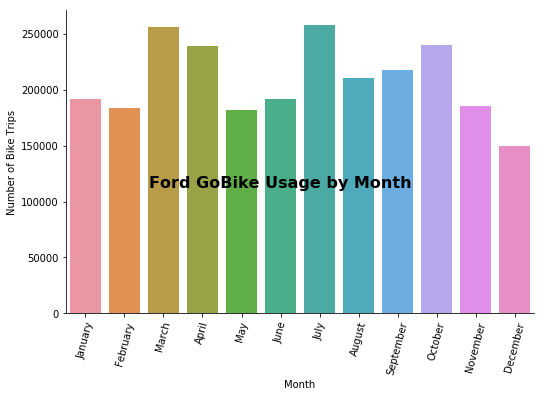

In [20]:
# Monthly usage of Ford Go Bike
graph = sb.catplot(data = df, x = 'start_time_month', kind = 'count', aspect = 1.5);

graph.set_axis_labels('Month', 'Number of Bike Trips'),

graph.fig.suptitle('Ford GoBike Usage by Month', y = 0.5, fontsize = 16, fontweight = 'bold');

graph.set_xticklabels(rotation=75);

#### We see that thet month of July has the highest number of rides booked followed by March and October. Lowest number of rides booked in December

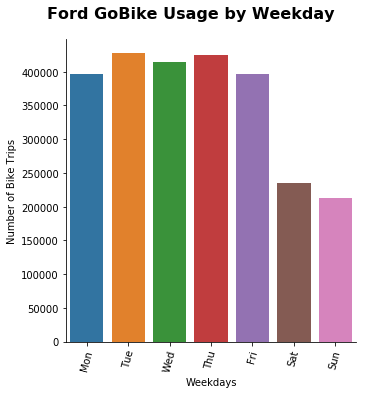

In [21]:
# Weekday usage of the Ford Go bike system
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

graph = sb.catplot(data=df, x='start_day_of_week', kind='count', order = weekday)

graph.set_axis_labels('Weekdays', 'Number of Bike Trips')

graph.fig.suptitle('Ford GoBike Usage by Weekday', y=1.05, fontsize=16, fontweight='bold');

graph.set_xticklabels(rotation=75);

#### Week days of are the ones where we have the most usage with saturday and sunday the usage going down significantly. This suggest that the bikes are mostly used for commuting for work

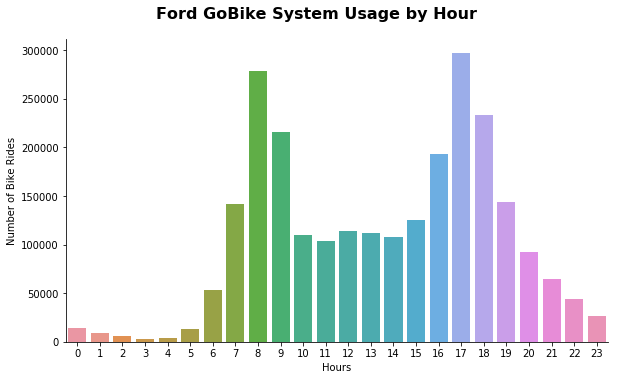

In [22]:
# Hourly usage of the Ford Go Bike System
graph = sb.catplot(data = df, x='starting_hour', kind='count', aspect = 1.7)

graph.set_axis_labels('Hours', 'Number of Bike Rides')

graph.fig.suptitle('Ford GoBike System Usage by Hour', y=1.05, fontsize=16, fontweight='bold');

#### As observed in the previous chart that the bikes are used for office commutes, we get this as true looking at the usage pattern by the hour. We see that the peek usage time is between 7-10 am and 4-7 pm

In [23]:
# Calculate the mean to know average time a trip lasts
df.duration_min.mean()

12.969462497352396

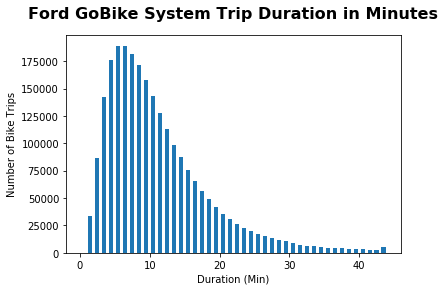

In [24]:
# Plot a chart showing average travel time in minutes

# Duration of the bike rides -in MINUTES
bins = np.arange(0, 45, 1)
plt.hist(data = df, x = 'duration_min', bins = bins, rwidth = 0.6);

plt.title("Ford GoBike System Trip Duration in Minutes", y=1.05, fontsize=16, fontweight='bold')
plt.xlabel('Duration (Min)')
#plt.xticks(ticks, labels)
plt.ylabel('Number of Bike Trips');

#### Average travel time is just under 13 mins for each trip qith most of the trips falling under 5 - 15 mins


## Typical Distance covered

Since customers use the bike sharing system are using this system for daily commute they are travelling on an average 1.6 kilometers on each trip.

In [25]:
# Calculate the travel distance for each trip
df.distance_km.mean()

1.6721465602279713

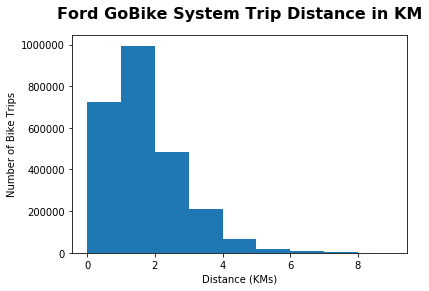

In [26]:
# Plot a chart to see the spread of values
bins = np.arange(0, 10, 1)

plt.hist(data = df, x = 'distance_km', bins = bins);

plt.title("Ford GoBike System Trip Distance in KM", y=1.05, fontsize=16, fontweight='bold')
plt.xlabel('Distance (KMs)')
plt.ylabel('Number of Bike Trips');

#### Maximum trip distance is around 1.6 kms, with majority of rides falling under 4 kms.

## Subscriber Vs Customer usage

Below we can see that majority of the users are of type subscriber who are the regular users of this system. A small portion is made up of users who are not regular

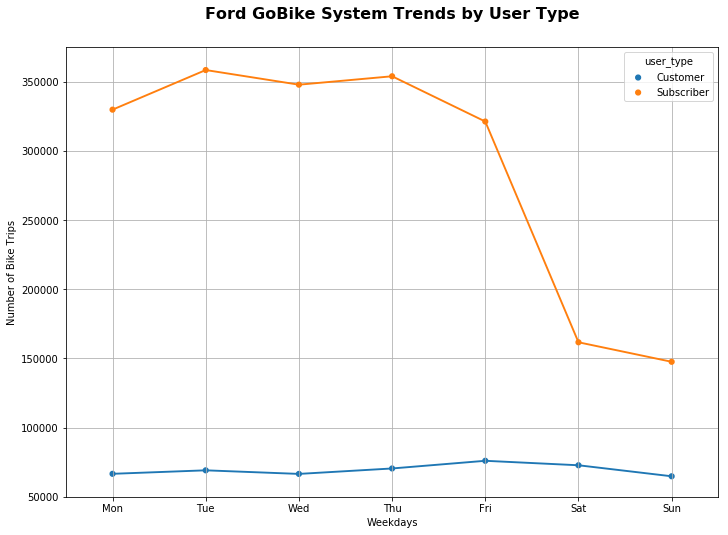

In [34]:
# Customer Usage by Weekday vs. Subscriber Usage by Weekday

plt.figure(figsize=[ 11.69, 8.27]);

df_temp = df.groupby(['start_day_of_week', 'user_type']).size().reset_index()
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

ax = sb.pointplot(data=df_temp, x='start_day_of_week', y=0, hue = 'user_type', scale=.7, order = weekday);

plt.title('Ford GoBike System Trends by User Type', y=1.05, fontsize=16, fontweight='bold')
plt.xlabel('Weekdays')
plt.ylabel('Number of Bike Trips');
plt.grid()

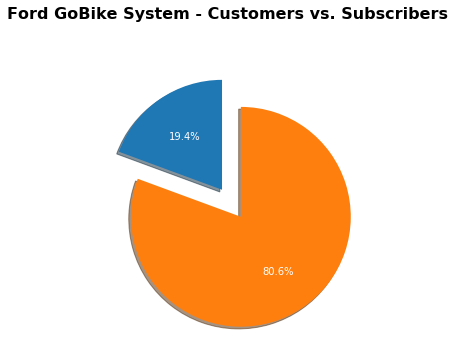

In [27]:
# Lets get details on how subscribers and customer relate

customer = df.query('user_type == "Customer"')['bike_id'].count()
subscriber = df.query('user_type == "Subscriber"')['bike_id'].count()
customer_prop = customer / df['bike_id'].count()
subscriber_prop = subscriber / df['bike_id'].count()

# Plot a chart to see the visual
plt.figure(figsize = [8, 5])

labels = ['Customer', 'Subscriber']
size = [customer_prop, subscriber_prop]
explode = (0, 0.3)

plt.pie(size, explode=explode, labels = labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'color':'white'})
plt.axis('equal')

plt.suptitle('Ford GoBike System - Customers vs. Subscribers', y=1.05, fontsize=16, fontweight='bold');

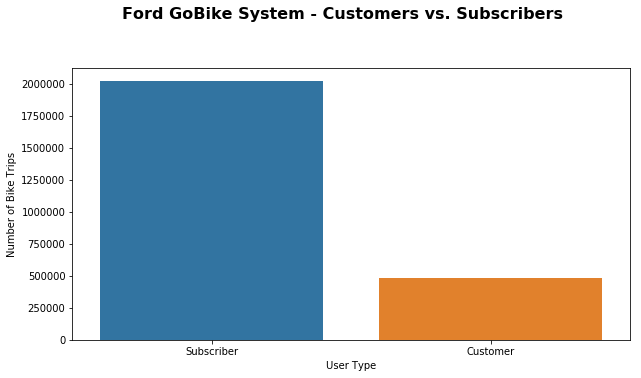

In [28]:
# plot a bar chart

plt.figure(figsize = [10, 5])

graph = sb.countplot(data = df, x = "user_type", order = df.user_type.value_counts().index);
graph.set_xlabel('User Type');
graph.set_ylabel('Number of Bike Trips');
plt.suptitle('Ford GoBike System - Customers vs. Subscribers', y=1.05, fontsize=16, fontweight='bold');

#### The system is mostly used by subscribers which reveals that most are regular users

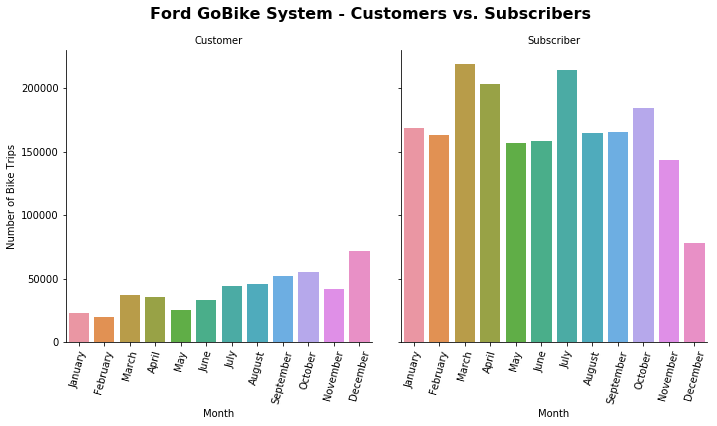

In [29]:
# Monthly usage - user type

graph = sb.catplot(data=df, x='start_time_month', col="user_type", kind='count', sharey = True);

graph.set_axis_labels("Month", "Number of Bike Trips");
graph.set_titles("{col_name}");

graph.fig.suptitle('Ford GoBike System - Customers vs. Subscribers', y=1.05, fontsize=16, fontweight='bold');
graph.set_xticklabels(rotation=75);

C:\Users\ma501v\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


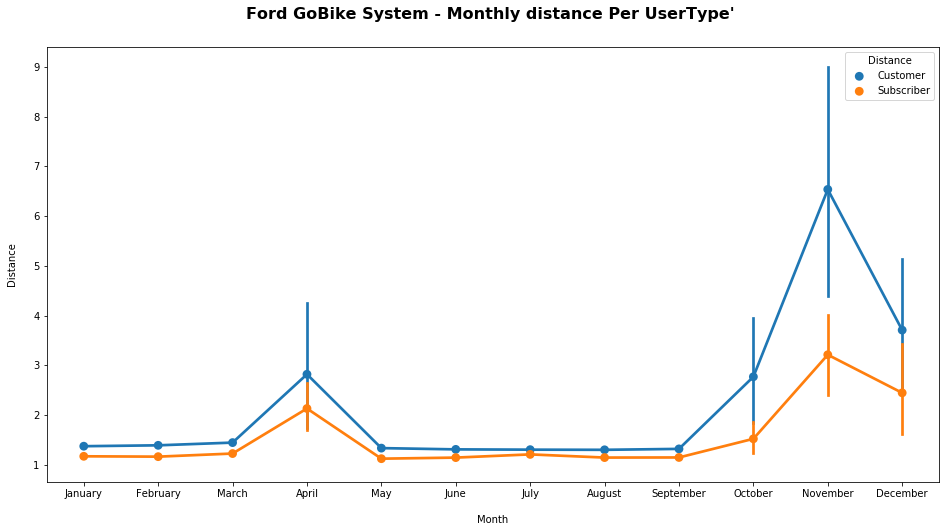

In [30]:
# Comparing monthly number of bike trips per subscribers, based on distance covered

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig = plt.figure(figsize = [16,8])
ax = sb.pointplot(data = df, x='start_time_month', y='distance_km', hue='user_type',  order = months);

plt.xlabel('Month', labelpad = 16)
plt.ylabel('Distance', labelpad = 16)
plt.title("Ford GoBike System - Monthly distance Per UserType' ", y = 1.05, fontsize = 16, fontweight = 'bold');


# Legend
leg = ax.legend()
leg.set_title('Distance')

plt.show()

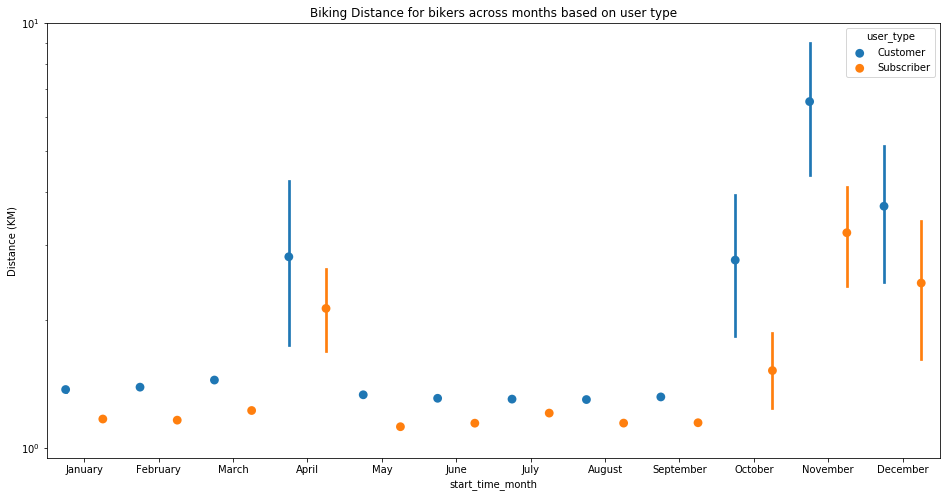

In [31]:
#Usertype and average distance traveled per month
fig = plt.figure(figsize = [16,8])

ax = sb.pointplot(data = df, x = 'start_time_month', y = 'distance_km', hue = 'user_type',
         linestyles = '', dodge = 0.5);

plt.title('Biking Distance for bikers across months based on user type');
plt.ylabel('Distance (KM)');
plt.yscale('log');

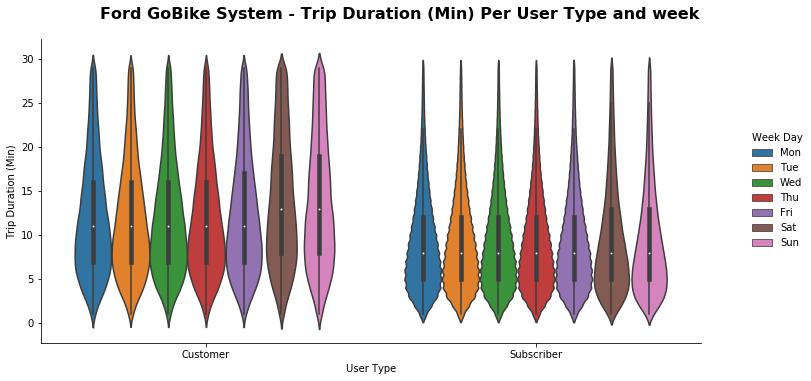

In [32]:
# Violinplot - duration (min) per user type per week
# removing some outliers in duration

data = df.query('duration_min < 30')

graph = sb.catplot(data=data, x='user_type', y="duration_min", hue="start_day_of_week", kind="violin", height=5, aspect=2);

graph.set_axis_labels("User Type", "Trip Duration (Min)")
graph._legend.set_title('Week Day')
graph.fig.suptitle('Ford GoBike System - Trip Duration (Min) Per User Type and week', y=1.05, fontsize=16, fontweight='bold');

#### Customer take longer than subscribers. this also strengths our ealier assumption that subscribers are using this service for commuting regularly where as customers using for joy ride.


### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

        The features investigated here are pretty much indenpendant from each other I suppose so I did not observe any  features that strengthened each other in terms of looking at features.

### Were there any interesting or surprising interactions between features?

       * Bike rides in month of April and October, NOvember, December have longer Distances compared to bike rides on other months.
       * Customer type users dominate the trip distance covered in a particular month.
       * 'Customer' bikers bike longer on average compared to 'Subscriber' bikers.
       * The bikers are the least in 3:00 AM and 4:00 AM.
       * There are less bikers on Saturday and on Sundays on average.
       * Winter months attract more bikers
       * Most users of bikes are Subscribers for daily use mostly for commute

